<a href="https://colab.research.google.com/github/teymour-aldridge/NN/blob/master/computer_vision/malaria_detection/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Set the default device (either cpu or gpu) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Download files

The first command `!wget ... ` downloads the data files from the NIH servers. The quotes following `-P` specifies the path (https://en.wikipedia.org/wiki/Path_(computing)) where the zip file will be saved to. By editing this, you can save the files to a different directory, e.g. `!wget -P "/Users/<your username>/Desktop" https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip` would save the files on your Desktop (on a Linux or Unix machine).

The second command `!unzip ...` unzips the files. You can manually unzip the files (by clicking on the file) as well. The flag `-q` tells the command to run quietly (it doesn't print the names of all 20,000 and something files into the console). The argument passed to the `-d` flag (the text in quotes after the `-d`) specifies where the file should be saved. The text after the `-q` flag specifies where the file has been saved.

In [0]:
# !wget -P "/content/gdrive/My Drive/Computing/ML/Computer Vision/Malaria detection/" https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

In [0]:
# !unzip -q "/content/gdrive/My Drive/Computing/ML/Computer Vision/Malaria detection/cell_images.zip" -d "/content/gdrive/My Drive/Computing/ML/Computer Vision/Malaria detection/"

# Data preprocessing

The `base_path` variable is a path to the directory in which the zip file has been extracted to. 
`model_save_path` specifies where the parameters of our machine learning model should be saved to. 

In [0]:
base_path = "/content/gdrive/My Drive/Computing/ML/Computer Vision/Malaria detection/cell_images"
model_save_path = "/content/gdrive/My Drive/Computing/ML/Computer Vision/Malaria detection/"

## Dataset class

## Indices

Here we create an index, specifying where all the files are and whether they are images of parasitized or uninfected cells. 

In [0]:
import os
import pandas as pd

# This takes time as there are 20,000 images

classes = {
    'Parasitized': 1,
    'Uninfected': 0
}

train_index = pd.DataFrame(columns=['class', 'path'])
test_index = pd.DataFrame(columns=['class', 'path'])

# Iterate through the (two) directories where the data is stored
# os.listdir() returns a list with the content of the directory specified, in this case the variable `base_path`
# The list returned will look like this: ['Parasitized', 'Uninfected']. We want to iterate through these two folders
# and add 80% of these files to our training dataset and 20% to our test dataset.
for dir in os.listdir(base_path):
  # Generate an index for the directory we are in (either the one with parasitized cells or the one with 
  # uninfected cells)
  directory_index = os.listdir(os.path.join(base_path, dir))
  # len(directory_index)*4/5 means that 80% of the dataset will be for training as we go from item 0 (computers count
  # from 0) to the item at len(directory_index)*4/5. We convert this into an int as python cannot iterate to floats
  for i in range(int(len(directory_index)*(4/5))):
    train_index = train_index.append({
        'class': classes[dir],
        'path': os.path.join(base_path, dir, directory_index[i])
    }, ignore_index = True)
  # The remaining 20% of the dataset is left for testing
  for i in range(int(len(directory_index)*(4/5)), len(directory_index)):
    test_index = test_index.append({
        'class': classes[dir],
        'path': os.path.join(base_path, dir, directory_index[i])
    }, ignore_index = True)

In [0]:
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
from PIL import Image
class IndexedImageDataset(Dataset):
    def __init__(self, index, transform=None):
      
        assert isinstance(index, pd.DataFrame)
        # Randomly shuffle the index
        self.index = shuffle(index)
        self.transform = transform
        self.transform = transform

    def __len__(self):
        return len(self.index.index)  

    def __getitem__(self, n):
        x, y = self.index['path'].iloc[n], self.index['class'].iloc[n]
        x = Image.open(x)
          
        if self.transform:
          x = self.transform(x)
        
        # Convnets want double tensors
        x.double()
        
        return x, y

In [0]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

train_dataset = IndexedImageDataset(train_index, transform)
test_dataset = IndexedImageDataset(test_index, transform)

<class 'torch.Tensor'>


1

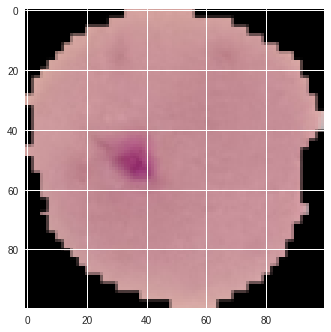

In [0]:
print(type(train_dataset[50][0]))
plt.imshow(transforms.ToPILImage()(train_dataset[50][0]))
train_dataset[50][0].shape
train_dataset[50][1]

In [0]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=8,
    shuffle=False
)

# Neural network

In [0]:
from torch import nn
import torch.nn.functional as F

class MalariaNetwork(nn.Module):
  def __init__(self, num_classes=2):
    super(MalariaNetwork, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=4, padding=1).double()
    self.conv2 = nn.Conv2d(16, 32, kernel_size=4, padding=1).double()
    self.conv3 = nn.Conv2d(32, 64, kernel_size=4, padding=1).double()
    self.conv4 = nn.Conv2d(64, 128, kernel_size=4, padding=1).double()
    self.fc = nn.Linear(128*5*5, 64)
    self.fc2 = nn.Linear(64, num_classes)
  def forward(self, x):
    x = x.to(device)
    x = x.double()
    x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
    x = F.max_pool2d(torch.tanh(self.conv3(x)), 2)
    x = F.max_pool2d(torch.tanh(self.conv4(x)), 2)
    
    x = x.reshape(x.size(0), -1).float()
    
    x = torch.tanh(self.fc(x))
    x = self.fc2(x)
    return F.softmax(x)

In [0]:
n_epochs = 100
model = MalariaNetwork()
model.to(device)
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

CrossEntropyLoss()

In [0]:
import os
loop_count = os.path.join(model_save_path, 'epoch.txt')
model_path = os.path.join(model_save_path, 'malaria_model_weights.pt')

if os.path.isfile(loop_count): # Resume training from earlier save
  
  with open(os.path.join(loop_count)) as epoch_count:
    epoch_number = int(epoch_count.read())
    print("Picked up from: " + str(epoch_number))
  print(os.path.isfile(model_path))
  model.load_state_dict(torch.load(model_path))


else:
  
  epoch_number = 0 # Start from epoch 0


temp_losses = 0
loss_length = 0

for epoch in range(epoch_number, n_epochs):
  
  for imgs, labels in train_loader:
    
    imgs.to(device)
    labels.to(device)
    
    outputs = model(imgs)
    outputs.to(device)
    
    loss = loss_fn(outputs, labels.cuda())
    
    temp_losses+=loss
    loss_length+=1
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_average = temp_losses/loss_length
  loss_length = 0
  temp_losses = 0

  
  print("Epoch: %d, Loss: %f" % (epoch, loss_average))
  
  torch.save(model.state_dict(), os.path.join(model_save_path, 'malaria_model_weights.pt'))
  
  with open(os.path.join(model_save_path, 'epoch.txt'), 'w+') as epoch_count:
    print("Saved epoch number.")
    epoch_count.write(str(epoch))
    
  with open(os.path.join(model_save_path, 'losses.txt'), 'a+') as loss_file:
    loss_file.write(str(loss_average) + "\n")
  

Picked up from: 99
True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 99, Loss: 0.351285
Saved epoch number.


In [0]:
# Evaluate model
model.load_state_dict(torch.load(os.path.join(model_save_path, 'malaria_model_weights.pt')))
from IPython.display import clear_output
model.eval()
n=1
print(test_dataset[n][1])
x=model(torch.unsqueeze(test_dataset[n][0], 0))
n_false=0
i=0
l=0
print(len(test_dataset))
for img, label in test_dataset:
  pred = model(torch.unsqueeze(img, 0))
  pred = torch.argmax(pred)
  if i%1==0:
    print(str(round(i/len(test_dataset)*100))+"%")
  if l%100==0:
    clear_output()
  i+=1
  if pred!=label:
    n_false+=1

## Accuracy

In [0]:
print(str((1-(n_false/len(test_dataset)))*100) + "%")

95.04716981132076%
